## Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(20,10)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

import warnings
warnings.filterwarnings('ignore')

## Get the Data

In [2]:
raw_df = pd.read_csv("all_songs.csv")

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17790 entries, 0 to 17789
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             17790 non-null  object 
 1   artist            17790 non-null  object 
 2   uri               17790 non-null  object 
 3   danceability      17790 non-null  float64
 4   energy            17790 non-null  float64
 5   key               17790 non-null  int64  
 6   loudness          17790 non-null  float64
 7   mode              17790 non-null  int64  
 8   speechiness       17790 non-null  float64
 9   acousticness      17790 non-null  float64
 10  instrumentalness  17790 non-null  float64
 11  liveness          17790 non-null  float64
 12  valence           17790 non-null  float64
 13  tempo             17790 non-null  float64
 14  duration_ms       17790 non-null  int64  
 15  time_signature    17790 non-null  int64  
 16  chorus_hit        17790 non-null  float6

In [4]:
raw_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,1990
1,Never Ever,All Saints,spotify:track:5FTz9qQ94PyUHETyAyfYZN,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,387573,4,32.16853,16,1,1990
2,Soul Sermon,Gregg Karukas,spotify:track:6m24oe3lk1UMxq9zq4iPFi,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,237267,4,42.05369,9,0,1990
3,Clarinet Marmalade - Live,Alton Purnell,spotify:track:5FOXuiLI6knVtgMUjWKj6x,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,375933,4,80.99693,10,0,1990
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,spotify:track:6CxyIPTqSPvAPXfrIZczs4,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,430653,4,25.57331,20,0,1990


In [5]:
raw_df['target'].value_counts()

0    8895
1    8895
Name: target, dtype: int64

In [6]:
raw_df.loc[raw_df['target'] == 1].groupby(['artist'])['track'].count().sort_values(ascending=False).head(10)

artist
Glee Cast        52
Taylor Swift     52
Drake            51
Tim McGraw       45
Kenny Chesney    43
Toby Keith       35
Keith Urban      35
Madonna          34
Brad Paisley     34
George Strait    34
Name: track, dtype: int64

In [7]:
raw_df['decade'].value_counts()

2010    6398
2000    5872
1990    5520
Name: decade, dtype: int64

In [82]:
feature_columns = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness','valence', 'loudness','tempo', 'duration_ms',
                   'time_signature', 'chorus_hit','sections']

danceability


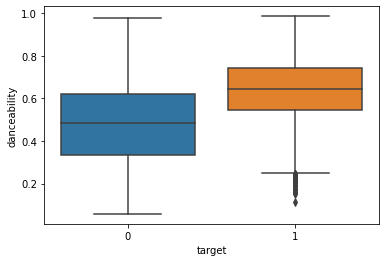

energy


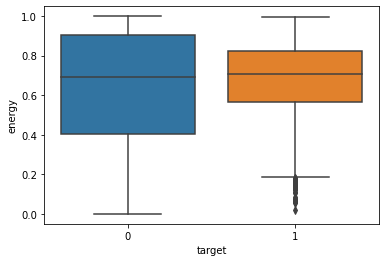

key


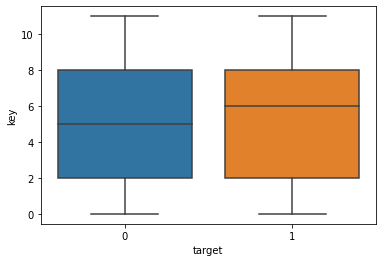

loudness


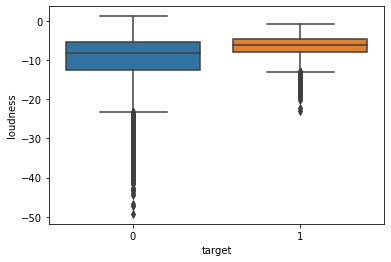

mode


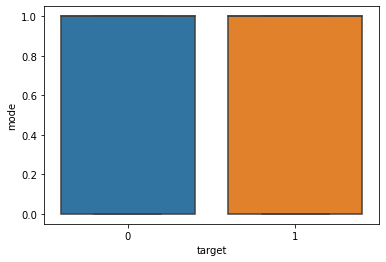

speechiness


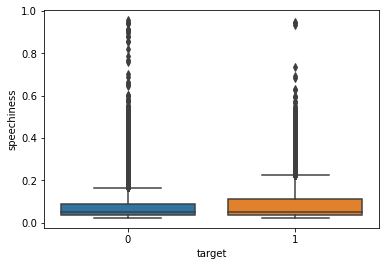

acousticness


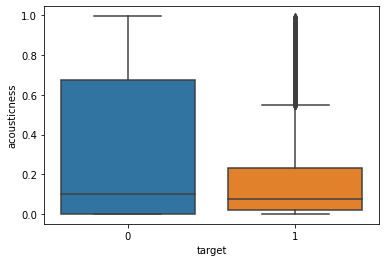

instrumentalness


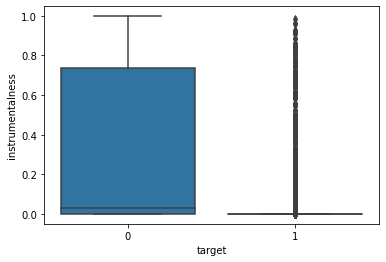

liveness


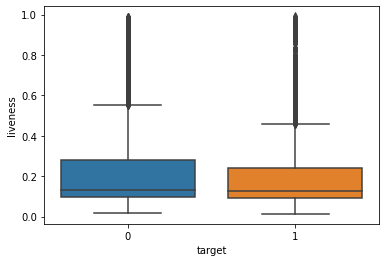

valence


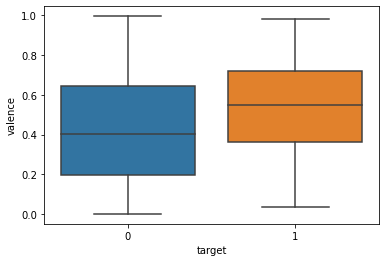

loudness


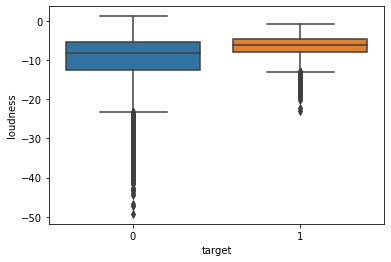

tempo


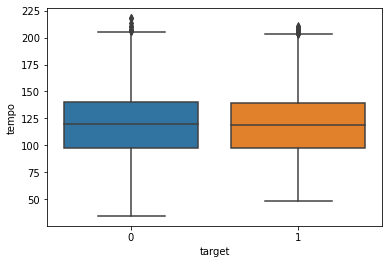

duration_ms


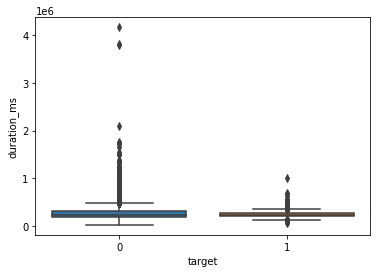

time_signature


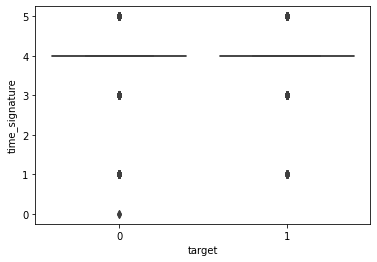

chorus_hit


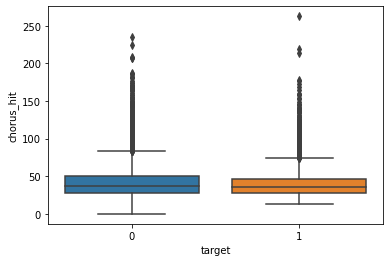

sections


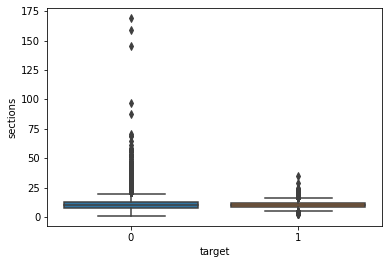

In [9]:
for feature in feature_columns:
    print(feature)
    sns.boxplot(x="target", y=feature, data=raw_df)
    plt.show()

We can clearly see that Danceability, Valence and Key have great impact on the target. 

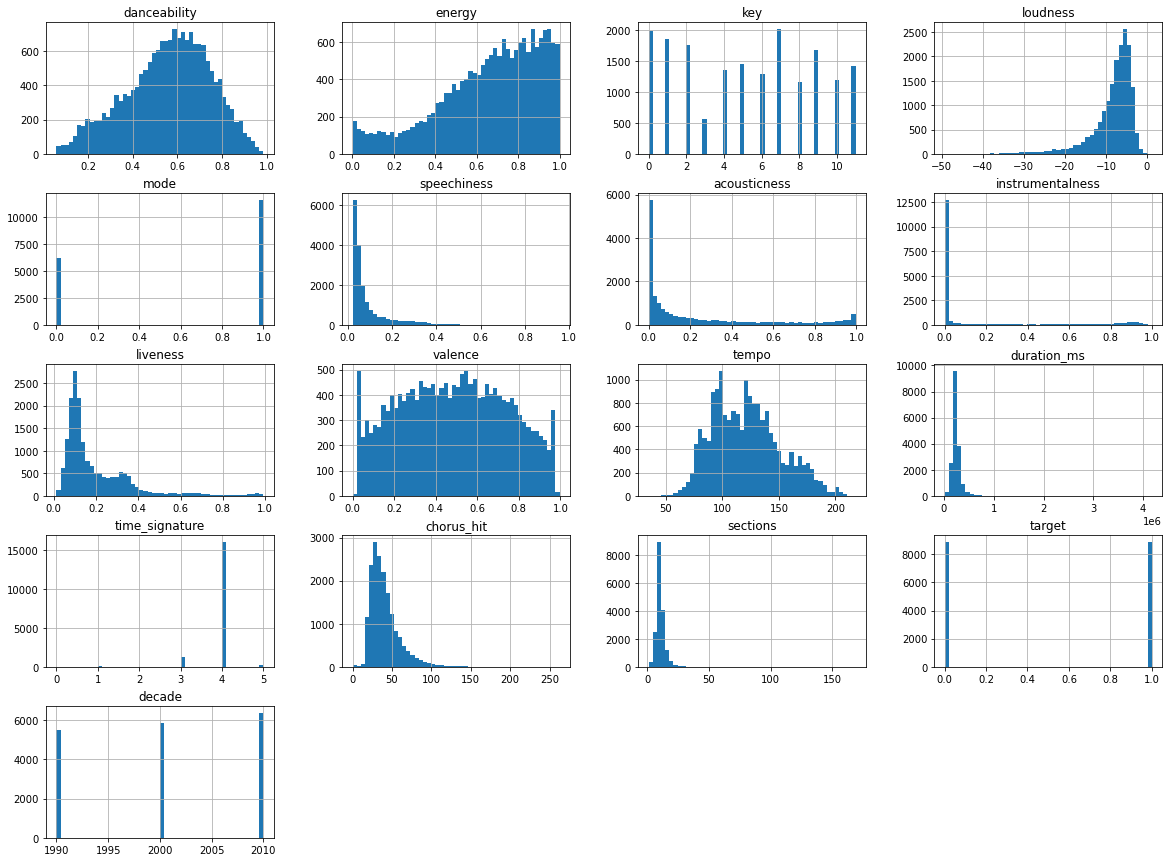

In [10]:
raw_df.hist(bins=50,figsize=(20,15))
plt.show()

## Random Forest Classification Model

In [33]:
df = raw_df

In [196]:
columns = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness','valence', 'loudness','tempo', 'duration_ms',
                   'time_signature', 'chorus_hit','sections', 'target']

In [38]:
df_filtered = df[columns]

In [42]:
df_full_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [43]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [44]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [45]:
del df_train['target']
del df_val['target']
del df_test['target']

## Tuning max depth parameter

In [46]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        model = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=0)
        model.fit(df_train, y_train)

        y_pred = model.predict_proba(df_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [47]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

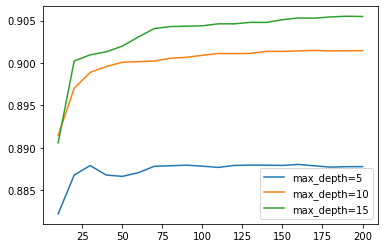

In [48]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

## Tuning min samples leaf parameter

In [49]:
max_depth = 10

In [50]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(df_train, y_train)

        y_pred = rf.predict_proba(df_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [51]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

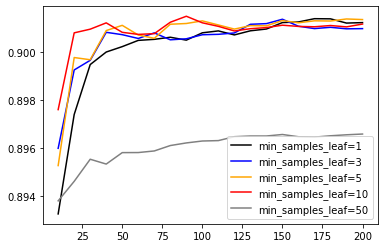

In [52]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [55]:
min_samples_leaf = 5
n_estimators = 200

In [57]:
model = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
model.fit(df_train, y_train)
y_pred = model.predict(df_test)

In [58]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
display(confusion_matrix)

array([[1354,  401],
       [ 208, 1595]], dtype=int64)

In [59]:
model.feature_importances_

array([0.15910916, 0.07136163, 0.00642518, 0.0590421 , 0.00250199,
       0.02966802, 0.11058233, 0.32464444, 0.01511067, 0.04231788,
       0.06428258, 0.0148049 , 0.07270437, 0.00181439, 0.01071395,
       0.01491641])

In [60]:
feature_importance = model.feature_importances_
df_feature_names = pd.DataFrame(feature_columns)
df_importance = pd.DataFrame(feature_importance)
df_feat_importance = pd.concat([df_feature_names, df_importance], axis = 1)
df_feat_importance.columns = ['feature', 'importance']
df_feat_importance = df_feat_importance.set_index('feature')
df_feat_importance = df_feat_importance.sort_values(by=['importance'], ascending = False)

In [61]:
df_feat_importance

,importance
feature,
instrumentalness,0.324644
danceability,0.159109
acousticness,0.110582
duration_ms,0.072704
energy,0.071362
loudness,0.064283
loudness,0.059042
valence,0.042318
speechiness,0.029668


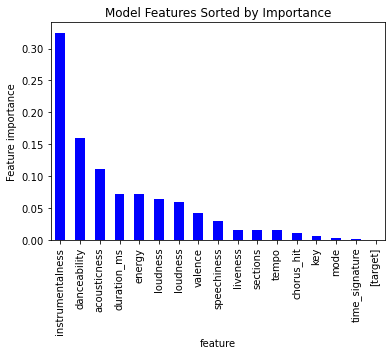

In [62]:
df_feat_importance.plot(kind='bar', color = "blue", title = "Model Features Sorted by Importance", legend = None)
plt.ylabel('Feature importance')
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [63]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8288364249578415
Precision: 0.7990981963927856
Recall: 0.884636716583472


## Testing the Model

In [75]:
new_song = df_test.loc[70]
new_song

danceability             0.69000
energy                   0.45200
key                      0.00000
loudness               -12.92700
mode                     1.00000
speechiness              0.04110
acousticness             0.02930
instrumentalness         0.26000
liveness                 0.06720
valence                  0.69500
loudness               -12.92700
tempo                  152.81400
duration_ms         342160.00000
time_signature           4.00000
chorus_hit              19.67449
sections                14.00000
Name: 70, dtype: float64

In [76]:
model.predict_proba([new_song])[0,1]

0.24402748723740686

In [74]:
df_test.loc[70]

danceability             0.69000
energy                   0.45200
key                      0.00000
loudness               -12.92700
mode                     1.00000
speechiness              0.04110
acousticness             0.02930
instrumentalness         0.26000
liveness                 0.06720
valence                  0.69500
loudness               -12.92700
tempo                  152.81400
duration_ms         342160.00000
time_signature           4.00000
chorus_hit              19.67449
sections                14.00000
Name: 70, dtype: float64

In [73]:
y_test[70]

1

In [78]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\allak\anaconda3\python.exe -m pip install --upgrade pip' command.


In [79]:
import xgboost as xgb

In [83]:
feature_columns

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'loudness',
 'tempo',
 'duration_ms',
 'time_signature',
 'chorus_hit',
 'sections']

In [94]:
df_train = df_train.loc[:,~df_train.columns.duplicated()]
df_test = df_test.loc[:,~df_test.columns.duplicated()]
df_val = df_val.loc[:,~df_val.columns.duplicated()]

In [95]:
dtrain = xgb.DMatrix(df_train, label=y_train)
dval = xgb.DMatrix(df_val, label=y_val)

In [96]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [97]:
y_pred = model.predict(dval)

In [98]:
roc_auc_score(y_val, y_pred)

0.9031473049441668

In [99]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [100]:


%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)



In [101]:
s = output.stdout

In [104]:
print(s[:500])

[0]	train-auc:0.88375	val-auc:0.87248
[5]	train-auc:0.92286	val-auc:0.89724
[10]	train-auc:0.93538	val-auc:0.90385
[15]	train-auc:0.94146	val-auc:0.90615
[20]	train-auc:0.94980	val-auc:0.90614
[25]	train-auc:0.95533	val-auc:0.90633
[30]	train-auc:0.95967	val-auc:0.90673
[35]	train-auc:0.96429	val-auc:0.90672
[40]	train-auc:0.96890	val-auc:0.90693
[45]	train-auc:0.97266	val-auc:0.90668
[50]	train-auc:0.97614	val-auc:0.90578
[55]	train-auc:0.97930	val-auc:0.90409
[60]	train-auc:0.98141	val-auc:0.9


In [105]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [106]:
df_score = parse_xgb_output(output)

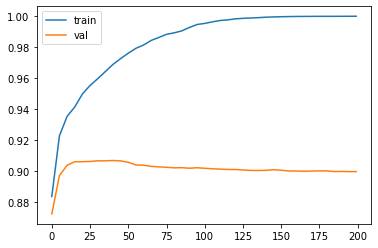

In [107]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

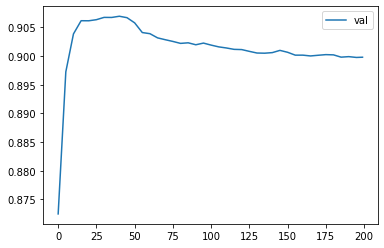

In [108]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## XGBoost Parameter tuning

In [150]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']
scores = {}

In [155]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [156]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [157]:
scores

{'eta=1':     num_iter  train_auc  val_auc
 0          0    0.88375  0.87248
 1          5    0.93792  0.88722
 2         10    0.95680  0.88819
 3         15    0.97052  0.88262
 4         20    0.98189  0.88175
 5         25    0.98801  0.88017
 6         30    0.99349  0.87926
 7         35    0.99697  0.87783
 8         40    0.99863  0.87997
 9         45    0.99944  0.87826
 10        50    0.99987  0.87922
 11        55    0.99995  0.88071
 12        60    0.99999  0.88224
 13        65    1.00000  0.88253
 14        70    1.00000  0.88359
 15        75    1.00000  0.88343
 16        80    1.00000  0.88324
 17        85    1.00000  0.88338
 18        90    1.00000  0.88365
 19        95    1.00000  0.88504
 20       100    1.00000  0.88511
 21       105    1.00000  0.88582
 22       110    1.00000  0.88661
 23       115    1.00000  0.88661
 24       120    1.00000  0.88680
 25       125    1.00000  0.88694
 26       130    1.00000  0.88665
 27       135    1.00000  0.88696
 28  

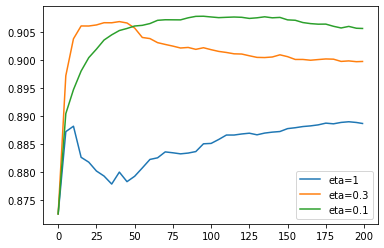

In [158]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

In [159]:
scores = {}

In [178]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [179]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=20'

In [172]:
del scores['max_depth=3']

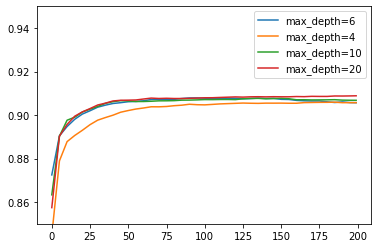

In [182]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.85, 0.95)    
plt.legend()

We can see that max_depth=6 is best depth.

In [183]:
scores = {}

In [188]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [189]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [191]:
scores

{'min_child_weight=1':     num_iter  train_auc  val_auc
 0          0    0.88375  0.87248
 1          5    0.90812  0.89045
 2         10    0.91844  0.89474
 3         15    0.92577  0.89807
 4         20    0.93028  0.90047
 5         25    0.93335  0.90199
 6         30    0.93658  0.90363
 7         35    0.93844  0.90456
 8         40    0.94049  0.90533
 9         45    0.94295  0.90570
 10        50    0.94494  0.90614
 11        55    0.94727  0.90626
 12        60    0.94946  0.90658
 13        65    0.95152  0.90716
 14        70    0.95333  0.90726
 15        75    0.95510  0.90725
 16        80    0.95733  0.90724
 17        85    0.95896  0.90761
 18        90    0.96024  0.90787
 19        95    0.96116  0.90789
 20       100    0.96222  0.90776
 21       105    0.96371  0.90764
 22       110    0.96534  0.90770
 23       115    0.96697  0.90775
 24       120    0.96788  0.90770
 25       125    0.96947  0.90750
 26       130    0.97091  0.90761
 27       135    0.97278  

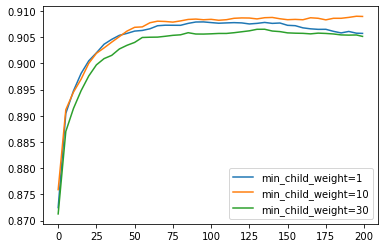

In [192]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

Seems like 10 is the best min_child_weight.

## Best Model

In [205]:
columns = ['danceability', 'energy', 'key','mode', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness','valence', 'loudness','tempo', 'duration_ms',
                   'time_signature', 'chorus_hit','sections', 'target']

In [206]:
df_full_train = df[columns].reset_index(drop=True)

In [207]:
y_full_train = df.target.values

In [208]:
del df_full_train['target']

In [210]:
df_train = df_train.loc[:,~df_train.columns.duplicated()]
df_test = df_test.loc[:,~df_test.columns.duplicated()]
df_val = df_val.loc[:,~df_val.columns.duplicated()]

In [212]:
dfulltrain = xgb.DMatrix(df_train, label=y_train)

dtest = xgb.DMatrix(df_test)

In [214]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)


In [215]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.9051024487519219

In [217]:
!pip install bentoml

  Using cached bentoml-1.0.10-py3-none-any.whl (873 kB)
  Using cached circus-0.17.1-py3-none-any.whl (182 kB)
  Using cached pip_requirements_parser-31.2.0-py3-none-any.whl (33 kB)
  Using cached rich-12.6.0-py3-none-any.whl (237 kB)
  Using cached opentelemetry_sdk-1.13.0-py3-none-any.whl (81 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached deepmerge-1.1.0-py3-none-any.whl (8.5 kB)
  Using cached opentelemetry_instrumentation_aiohttp_client-0.34b0-py3-none-any.whl (11 kB)
  Using cached fs-2.4.16-py2.py3-none-any.whl (135 kB)
  Using cached python_multipart-0.0.5-py3-none-any.whl
  Using cached watchfiles-0.18.1-cp37-abi3-win_amd64.whl (264 kB)
  Using cached pynvml-11.4.1-py3-none-any.whl (46 kB)
  Using cached aiohttp-3.8.3-cp39-cp39-win_amd64.whl (323 kB)
  Using cached simple_di-0.1.5-py3-none-any.whl (9.8 kB)
  Using cached python_json_logger-2.0.4-py3-none-any.whl (7.8 kB)
  Using cached schema-0.7.5-py2.py3-none-any.whl (17 kB)
  Using cached starlette-

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires Jinja2<3.0.0, but you have jinja2 3.1.2 which is incompatible.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 2.1.1 which is incompatible.
You should consider upgrading via the 'C:\Users\allak\anaconda3\python.exe -m pip install --upgrade pip' command.


In [218]:
import bentoml

In [219]:
bentoml.xgboost.save_model('spotify_hit_model',
                            model)

Model(tag="spotify_hit_model:a6leqrla4omzuacq", path="C:\Users\allak\bentoml\models\spotify_hit_model\a6leqrla4omzuacq\")